<a href="https://colab.research.google.com/github/PetchMa/NTF_SETI_RFI/blob/master/Noise_Non_Negative_Matrix_Factor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install setigen 
# !pip install blimpy
%matplotlib inline

     |████████████████████████████████| 6.4MB 6.7MB/s 
     |████████████████████████████████| 276kB 41.6MB/s 
     |████████████████████████████████| 4.8MB 47.6MB/s 


In [0]:
import pylab as plt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from random import seed
from random import random
from astropy import units as u
import setigen as stg
# from blimpy import Waterfall

def draw(fchans, tchans):
  random_num = int(random()*fchans/2)
  random_num_2 = int(random()*fchans/2)

  frame = stg.Frame(fchans=fchans*u.pixel,
                    tchans=tchans*u.pixel,
                    df=2.7939677238464355*u.Hz,
                    dt=18.25361108*u.s,
                    fch1=6095.214842353016*u.MHz)
  noise = frame.add_noise(x_mean=1, x_std=1, x_min=0)
  frame.add_signal(stg.constant_path(f_start=frame.get_frequency(random_num),
                                    drift_rate=0.5*u.Hz/u.s),
                  stg.constant_t_profile(level=10),
                  stg.gaussian_f_profile(width=20*u.Hz),
                  stg.constant_bp_profile(level=1))
  frame.add_signal(stg.constant_path(f_start=frame.get_frequency(random_num_2),
                                    drift_rate=0.1*u.Hz/u.s),
                  stg.constant_t_profile(level=10),
                  stg.gaussian_f_profile(width=20*u.Hz),
                  stg.constant_bp_profile(level=1))
  unique = int(random()*fchans/2)
  driftrate_unique = int(random()*2)-1
  frame.add_signal(stg.constant_path(f_start=frame.get_frequency(unique),
                                    drift_rate=driftrate_unique*u.Hz/u.s),
                  stg.constant_t_profile(level=10),
                  stg.gaussian_f_profile(width=20*u.Hz),
                  stg.constant_bp_profile(level=1))


  frame2 = stg.Frame(fchans=fchans*u.pixel,
                    tchans=tchans*u.pixel,
                    df=2.7939677238464355*u.Hz,
                    dt=18.25361108*u.s,
                    fch1=6095.214842353016*u.MHz)
  noise = frame2.add_noise(x_mean=1, x_std=1, x_min=0)
  frame2.add_signal(stg.constant_path(f_start=frame2.get_frequency(random_num),
                                    drift_rate=0.5*u.Hz/u.s),
                  stg.constant_t_profile(level=10),
                  stg.gaussian_f_profile(width=20*u.Hz),
                  stg.constant_bp_profile(level=1))
  frame2.add_signal(stg.constant_path(f_start=frame2.get_frequency(random_num_2),
                                    drift_rate=0.1*u.Hz/u.s),
                  stg.constant_t_profile(level=10),
                  stg.gaussian_f_profile(width=20*u.Hz),
                  stg.constant_bp_profile(level=1))
  unique = int(random()*fchans/2)
  driftrate_unique = int(random()*2)
  frame2.add_signal(stg.constant_path(f_start=frame2.get_frequency(unique),
                                    drift_rate=driftrate_unique*u.Hz/u.s),
                  stg.constant_t_profile(level=10),
                  stg.gaussian_f_profile(width=20*u.Hz),
                  stg.constant_bp_profile(level=1))


  return frame.get_data(),frame2.get_data()


In [0]:
def random_initialization(A,rank):
    number_of_documents = A.shape[0]
    number_of_terms = A.shape[1]
    W = np.random.uniform(1,2,(number_of_documents,rank))
    H = np.random.uniform(1,2,(rank,number_of_terms))
    return W,H
                          

def nndsvd_initialization(A,rank):
    u,s,v=np.linalg.svd(A,full_matrices=False)
    v=v.T
    w=np.zeros((A.shape[0],rank))
    h=np.zeros((rank,A.shape[1]))

    w[:,0]=np.sqrt(s[0])*np.abs(u[:,0])
    h[0,:]=np.sqrt(s[0])*np.abs(v[:,0].T)

    for i in range(1,rank):
        
        ui=u[:,i]
        vi=v[:,i]
        ui_pos=(ui>=0)*ui
        ui_neg=(ui<0)*-ui
        vi_pos=(vi>=0)*vi
        vi_neg=(vi<0)*-vi
        
        ui_pos_norm=np.linalg.norm(ui_pos,2)
        ui_neg_norm=np.linalg.norm(ui_neg,2)
        vi_pos_norm=np.linalg.norm(vi_pos,2)
        vi_neg_norm=np.linalg.norm(vi_neg,2)
        
        norm_pos=ui_pos_norm*vi_pos_norm
        norm_neg=ui_neg_norm*vi_neg_norm
        
        if norm_pos>=norm_neg:
            w[:,i]=np.sqrt(s[i]*norm_pos)/ui_pos_norm*ui_pos
            h[i,:]=np.sqrt(s[i]*norm_pos)/vi_pos_norm*vi_pos.T
        else:
            w[:,i]=np.sqrt(s[i]*norm_neg)/ui_neg_norm*ui_neg
            h[i,:]=np.sqrt(s[i]*norm_neg)/vi_neg_norm*vi_neg.T

    return w,h
def mu_method(A,k,W,H,max_iter,init_mode='random'):
    e = 1.0e-10
    for n in range(max_iter):
        # Update H
        W_TA = W.T@A
        W_TWH = W.T@W@H+e
        for i in range(np.size(H, 0)):
            for j in range(np.size(H, 1)):
                H[i, j] = H[i, j] * W_TA[i, j] / W_TWH[i, j]
        # Update W
        AH_T = A@H.T
        WHH_T =  W@H@H.T+ e

        for i in range(np.size(W, 0)):
            for j in range(np.size(W, 1)):
                W[i, j] = W[i, j] * AH_T[i, j] / WHH_T[i, j]
        # if n%5==0:
        #   f, axarr = plt.subplots(1,4, figsize=(25,60))
        #   axarr[0].imshow(A)
        #   axarr[1].imshow(W@H)
        #   axarr[2].imshow(W)
        #   # axarr[2].set_aspect('auto')
        #   axarr[3].imshow(H)
        #   f.savefig("/content/drive/My Drive/Deeplearning/factoring/combined/Matrix_approx_"+str(n)+".PNG", bbox_inches='tight')
        norm = np.linalg.norm(A - W@H, 'fro')
        if n%30==0:
          print("Update Loss -- "+str(n)+" ---- "+str(norm))
        
    return W ,H 


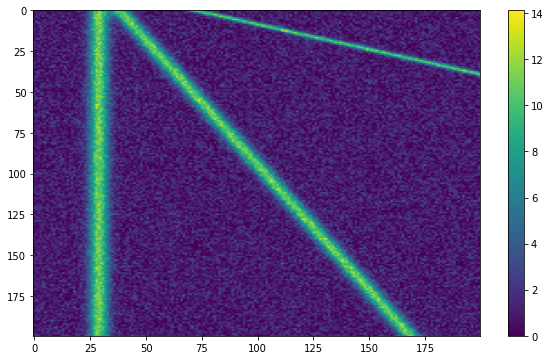

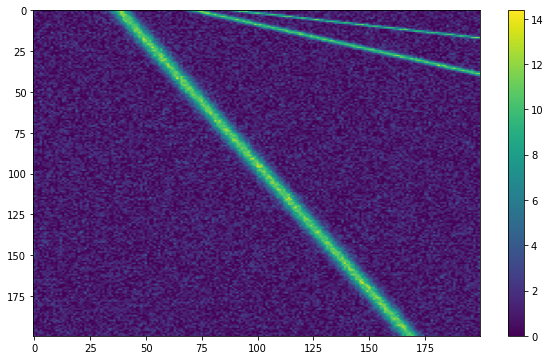

In [69]:
%matplotlib inline
A,B = draw(200,200)
fig = plt.figure(figsize=(10, 6))
plt.imshow(A, aspect='auto')
plt.colorbar()
fig = plt.figure(figsize=(10, 6))
plt.imshow(B, aspect='auto')
plt.colorbar()

In [70]:
import numpy as np
from copy import deepcopy
k = int(A.shape[0]/2)
W, H = random_initialization(A,k)
W_copy = deepcopy(W)
H_copy = deepcopy(H)
print("Training A")
W_A, H_A =  mu_method(A,k=k,max_iter=300,W=W,H=H, init_mode='random')

print("Training B")

W_B, H_B =  mu_method(B,k=k,max_iter=300,W=W_copy,H=H,init_mode='random')

Training A
Update Loss -- 0 ---- 383.67121794254456
Update Loss -- 30 ---- 161.51922154645604
Update Loss -- 60 ---- 137.0254765471279
Update Loss -- 90 ---- 125.28684610409202
Update Loss -- 120 ---- 119.03000569752271
Update Loss -- 150 ---- 115.64324245108249
Update Loss -- 180 ---- 113.58828357293257
Update Loss -- 210 ---- 112.2252134312648
Update Loss -- 240 ---- 111.24441031001729
Update Loss -- 270 ---- 110.49115295086168
Training B
Update Loss -- 0 ---- 277.8756105760836
Update Loss -- 30 ---- 124.35542097439355
Update Loss -- 60 ---- 119.89654813235606
Update Loss -- 90 ---- 117.67342851033747
Update Loss -- 120 ---- 116.14908296645172
Update Loss -- 150 ---- 115.08374781152274
Update Loss -- 180 ---- 114.3209518972082
Update Loss -- 210 ---- 113.70120978163257
Update Loss -- 240 ---- 113.2212319318206
Update Loss -- 270 ---- 112.78438353802467


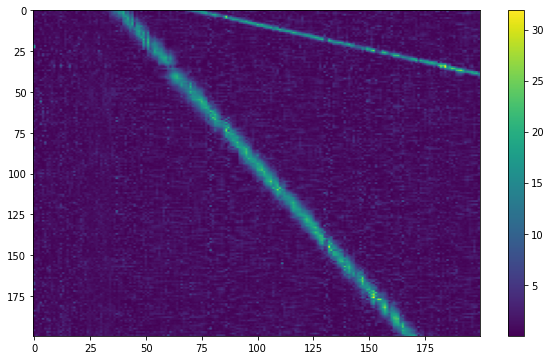

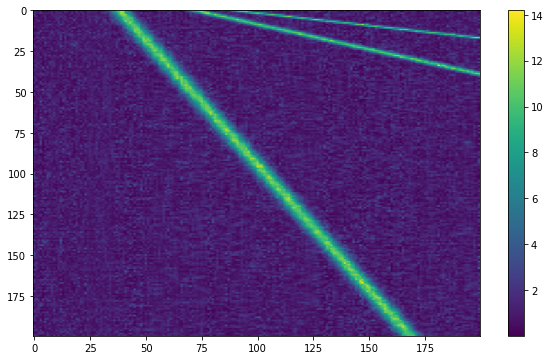

In [71]:
OG_A = W_A@ H_A
OG_B = W_B@ H_B
fig = plt.figure(figsize=(10, 6))
plt.imshow(OG_A, aspect='auto')
plt.colorbar()
fig = plt.figure(figsize=(10, 6))
plt.imshow(OG_B, aspect='auto')
plt.colorbar()

In [0]:
def zero_out(arr):
  for i in range(arr.shape[0]):
    for k in range(arr.shape[1]):
      if arr[i,k]<0.01:
        arr[i,k]=0
  return arr

def random_out(arr):
  for i in range(arr.shape[0]):
    for k in range(arr.shape[1]):
      if arr[i,k]<0.5:
        arr[i,k]=random()*2
  return arr

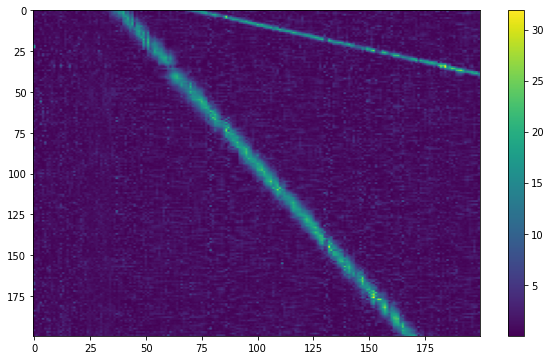

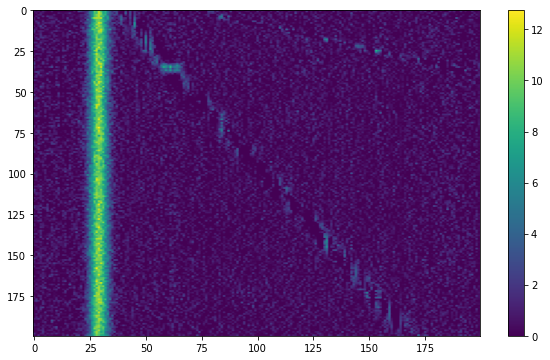

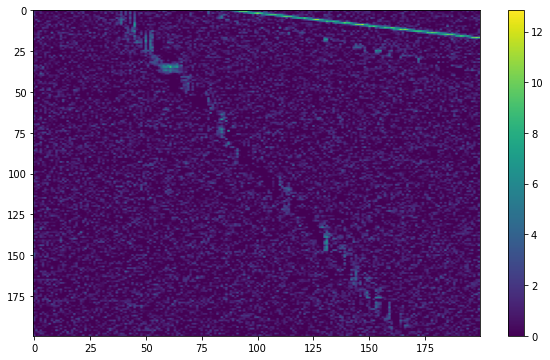

In [73]:
tune = 1.5
back = W_A@H_A
fig = plt.figure(figsize=(10, 6))
plt.imshow(back, aspect='auto')
plt.colorbar()

back = back *(A.max()/back.max())
result = A - back*tune 
result = zero_out(result)

fig = plt.figure(figsize=(10, 6))
plt.imshow(result, aspect='auto')
plt.colorbar()

back = W_A@ H_A
back = back *(B.max()/back.max())
result2 = B - back*tune 
result2 = zero_out(result2)

fig = plt.figure(figsize=(10, 6))
plt.imshow(result2, aspect='auto')
plt.colorbar()

In [0]:
OG_A = W_A@ H_A
OG_B = W_B@ H_B
direct_subtract = OG_A - OG_B

Cross_A = W_A@ H_B
Cross_B = W_B@ H_A
Cross_A = Cross_A *OG_B.max()/Cross_A.max()
layer = OG_B - Cross_A
Cross_B = Cross_B *OG_A.max()/Cross_B.max()
layer2 = OG_A - Cross_B


fig = plt.figure(figsize=(10, 6))
plt.imshow(direct_subtract, aspect='auto')
plt.colorbar()
fig = plt.figure(figsize=(10, 6))
plt.imshow(Cross_A, aspect='auto')
plt.colorbar()
fig = plt.figure(figsize=(10, 6))
plt.imshow(Cross_B, aspect='auto')
plt.colorbar()
fig = plt.figure(figsize=(10, 6))
plt.imshow(layer, aspect='auto')
plt.colorbar()
fig = plt.figure(figsize=(10, 6))
plt.imshow(layer2, aspect='auto')
plt.colorbar()

In [0]:
import numpy as np
import time
import cv2
stuff = cv2.imread("/content/NGC_4414_(NASA-med).jpg",cv2.IMREAD_GRAYSCALE)
A = cv2.resize(stuff, (100,100))
plt.title('')
plt.imshow(A, aspect='auto')


# f, axarr = plt.subplots(1,3, figsize=(25,60))
# f = plt.figure(figsize=(20, 20))
# axarr[0].imshow(A)
# axarr[1].imshow(A)
# axarr[2].imshow(A)

# f.savefig("stuff"+".PNG", bbox_inches='tight')

start = time.time()


w,h, norm =  mu_method(A,k=50,max_iter=300,init_mode='random')
elapsed = time.time()-start
print(elapsed)
# W, H, norms = mu_method(A=A,k=5,max_iter=30,init_mode='random')

error: ignored

In [0]:
print (A)

In [0]:
print(W@H)